# Rearrange files

# Config

In [1]:
import os

import fitz
import string
import fasttext

import enchant
from enchant.checker import SpellChecker
from enchant.errors import DictNotFoundError, DefaultLanguageNotFoundError

from tqdm import tqdm

from nltk.corpus import words
import nltk
nltk.download('words')

from deep_translator import GoogleTranslator
from googletrans import Translator
from collections import Counter

[nltk_data] Downloading package words to /home/lubrini/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
# import conversion tools
from tools.conv_tools import tools as ctools
from tools.conv_tools import ter
ter

Tools converting in the following extensions:
('pdf', 'png')
('[img]', 'pdf')
('png', 'txt')
('pdf', 'txt')
('pdf', 'txt')
('pdf', 'txt')
('pdf', 'txt')


{'pdf2img': 'pdf',
 'img2pdf': '[img]',
 'pytesseract_ocr': 'png',
 'PyPDF4_ocr': 'pdf',
 'pdfminer_ocr': 'pdf',
 'tika_ocr': 'pdf',
 'pdfreader_ocr': 'pdf'}

In [3]:
tools_for_conversion = ['pdfreader_ocr','pytesseract_ocr','tika_ocr','pdfminer_ocr','PyPDF4_ocr']

[('it_CH', <Enchant: Hunspell Provider>),
 ('it_IT', <Enchant: Hunspell Provider>)]

# Load and Rearrange Files

In [4]:
data_path = os.path.join('data')

input_path = os.path.join(data_path, 'docs')

ref_dir = 'ref'

doc_paths = [os.path.join(input_path, filepath) for filepath in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, filepath))]


In [5]:
## convert images to pdf
not_pdf_filepaths = [doc_path for doc_path in doc_paths if not doc_path.endswith('.pdf')]
for doc_path in not_pdf_filepaths:
    try:
        ctools.img2pdf(doc_path)
    except:
        print(doc_path)
        print('Warning: "{0}" extension not supported for conversion to pdf'.format(doc_path[:-4]))

In [6]:
## move files from input_path to their own directory
for doc_path in doc_paths:
    split_path = os.path.split(doc_path)
    new_dir_name = split_path[-1][:-4]
    filename = split_path[-1]
    new_dir_path = os.path.join(input_path,new_dir_name)
    new_doc_path = os.path.join(new_dir_path,filename)
    os.mkdir(new_dir_path)
    os.rename(doc_path,new_doc_path)

In [7]:
def mark_filename(file_path, mark):
    print('Marking filename...')
    ext = os.path.splitext(file_path)[-1]
    if ext=='pdf':
        path_no_ext = os.path.splitext(file_path)[-2][:-(len(ext))].replace(mark,"")
        print('path_no_ext:',path_no_ext)
        new_path = (str(path_no_ext)+mark+ext)
        print('new_path:',new_path)
        
        #os.rename(file_path,new_path)

def in_lang_wl(w, lang_code, max_error_count = 0):
                                d = SpellChecker(lang_code)
                                d.set_text(w)
                                errors = [err.word for err in d]
                                if (len(errors) > max_error_count):
                                    return True
                                else:
                                    return False

In [8]:
## rename files that do not have (usable) text embedded
lang_threshold = 0.90 # min percentage of words that need to be in a vocabulary for the embedded text to be considered usable
embedded_text_dir='embedded_txt'

for doc_dir in os.listdir(input_path):
    dir_path = os.path.join(input_path,doc_dir)
    for file_or_tool_name in os.listdir(dir_path):
        file_or_tool_path = os.path.join(dir_path,file_or_tool_name)
        if os.path.isfile(file_or_tool_path) and file_or_tool_path.endswith('pdf'):
            doc_path = file_or_tool_path 
            print('file_paths:',doc_path)

            # check if text is already embedded
            text = ""
            doc = fitz.open(doc_path)
            for page in doc:
                text += page.get_text()
            if text != '':
                # tokenise text
                doc_wordlist = list(set(text.translate(str.maketrans('', '', string.punctuation)).lower().split()))[-50:]
                prep_text = ' '.join(doc_wordlist)

                # get language of text
                lang_n = 1 # how many possible languages we want to detect
                model = fasttext.load_model(os.path.join('models','lid.176.ftz'))
                prediction = (model.predict(prep_text, k=lang_n))[0]
                languages = [label[-2:] for label in prediction]
                
                for lang_code in languages:
                    if not enchant.request_dict(lang_code):
                        print('WARNING: Install the required dictionary!\ne.g. sudo apt-get install hunspell-{0}'.format(lang_code))

                # check words exist in at least one vocabulary
                for lang_code in languages:
                    print('language:', lang_code)
                    lang_wordlist_path = os.path.join(data_path, 'wordlists',(lang_code+'.txt'))
                    # get wordlist from file ('en.txt' for english, 'fr.txt' for french, etc.)... 
                    if os.path.exists(lang_wordlist_path):
                        with open(lang_wordlist_path, 'rU') as f:
                            lang_wordlist = set(line.strip() for line in f)
                            
                            c=len([w for w in lang_wordlist for w in doc_wordlist])
                            print('COUNT (loaded wordlist):',c)
                    
                    else:
                        try:
                            c=len([w for w in doc_wordlist if in_lang_wl(w,lang_code)])
                            #print('COUNT (spellchecker):',c)
                        except (DictNotFoundError, DefaultLanguageNotFoundError):
                            raise Exception('Install the required dictionary!\ne.g. sudo apt-get install hunspell-{0}'.format(lang_code))

                        # ...if everything else fails, create wordlist (takes ages, download list if possible)
                        except AttributeError:
                            translator = Translator()
                            for en_w in tqdm(words.words()):
                                translation = (GoogleTranslator('en',lang_code).translate(en_w))
                                lang_wordlist.add(translation)

                                lang_wordlist
                                # save language wordlist
                                textfile = open(os.path.join(data_path,'wordlists',(lang_code+'.txt')), "w")
                                for w in lang_wordlist:
                                    textfile.write(w + "\n")
                                textfile.close()

                            c=len([w for w in lang_wordlist for w in doc_wordlist])
                            print('COUNT (translated wordlist):',c)
                        
                # if not, call function to mark filename as not having embedded text
                score = c/len(doc_wordlist) 
                if score < lang_threshold:
                    print('SCORE:',score)
                    print('Text is not usable! Score too low.')
                    unusable_path = os.path.join(dir_path,('UNUSABLE'+embedded_text_dir))
                    os.makedirs(unusable_path, exist_ok=True)
                    with open(os.path.join(unusable_path,'unusable_emb.txt'), 'w+') as f:
                        f.write(text)
                    mark_filename(file_path=doc_path,mark='_no-emb-txt_')
                else:
                    embedded_text_dir_path = os.path.join(dir_path,embedded_text_dir)
                    os.makedirs(embedded_text_dir_path, exist_ok=True)
                    embedded_text_path = os.path.join(embedded_text_dir_path,'emb.txt')
                    with open(embedded_text_path, 'w+') as f:
                        f.write(text)

            # if no text available, rename doc
            else:
                print('No text available!')
                mark_filename(file_path=doc_path,mark='_no-emb-txt_')
                

file_paths: data/docs/flyer_coleottero_giapponese/flyer_coleottero_giappone_zone_misure.pdf
language: it


SCORE: 0.3
Text is not usable! Score too low.
Marking filename...
file_paths: data/docs/1954_Blöte_Cacopsylla_pruni_Pays-Bas_Hollande_copie/1954_Blöte_Cacopsylla_pruni_Pays-Bas_Hollande_copie.pdf
language: nl


SCORE: 0.38
Text is not usable! Score too low.
Marking filename...
file_paths: data/docs/footnote/footnote.pdf
language: sv


SCORE: 0.54
Text is not usable! Score too low.
Marking filename...
file_paths: data/docs/1882_Scott_The_British_Psyllina,_with_corrections_in_the_synonomy_copie/1882_Scott_The_British_Psyllina,_with_corrections_in_the_synonomy_copie.pdf
No text available!
Marking filename...
file_paths: data/docs/sample_no_txt/sample_no_txt.pdf


language: de
SCORE: 0.78
Text is not usable! Score too low.
Marking filename...


In [9]:
#create labels
for doc_dir in os.listdir(input_path):
    dir_path = os.path.join(input_path,doc_dir)
    ref_path = os.path.join(dir_path,ref_dir)
    if not os.path.exists(ref_path):            # create ref dir if doesn't exist
        os.mkdir(ref_path)
        
        # add labels to their document's path
        for txt_file in os.listdir(dir_path):
            if txt_file.endswith('.txt'):
                os.rename(os.path.join(dir_path,txt_file),os.path.join(ref_path,txt_file))
    
    # create empty ref file if it doesn't exist
    if not os.listdir(ref_path):
        open(os.path.join(ref_path,'label_ref.txt'), 'w+').close()   


# Conversion and Evaluation

In [15]:
from tools.conv_tools import conv_ad_save
from tools.conv_classes import Doc, TxtConverter
from tools.eval_tools import get_cer

In [16]:
# create convertor instance from class
converter = TxtConverter(tools=ctools)

In [17]:
# for doc in data (each doc has its own directory)
print('Input_path:', input_path) 
cers = {} # CER scores

for dir in os.listdir(input_path):
    dir_path = os.path.join(input_path,dir)
    if embedded_text_dir not in os.listdir(dir_path):
        doc_paths = [os.path.join(dir_path, filepath) for filepath in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, filepath))]
        # create Doc instance with doc path
        doc_object = Doc(doc_paths, tools=ctools)
    
        ## CONVERSION
        conv_ad_save(dir_path,
                    doc_object,
                    converter,
                    tool_names=tools_for_conversion,
                    overwrite=False) # set to True to overwrite previous conversion exports 
        
        ## EVALUATION 
        doc_cer = get_cer(cers,
                doc_object,
                dir_path,
                ref_dir,
                source='obj')
                
        cers.update(doc_cer)
    else:
        print('Embedded text already exists for', dir)

print('Character Error Rates', cers)

Input_path: data/docs
Embedded text already exists for flyer_coleottero_giapponese
Embedded text already exists for 1954_Blöte_Cacopsylla_pruni_Pays-Bas_Hollande_copie
Converting: data/docs/footnote
{'original': [<_io.BufferedReader name='data/docs/footnote/footnote.pdf'>]}
tool_selection.keys() dict_keys(['PyPDF4_ocr', 'pdfminer_ocr', 'tika_ocr', 'pdfreader_ocr', 'pytesseract_ocr'])
tool_names ['pdfreader_ocr', 'pytesseract_ocr', 'tika_ocr', 'pdfminer_ocr', 'PyPDF4_ocr']


 40%|████      | 2/5 [00:03<00:05,  1.71s/it]2022-05-11 05:04:19,369 [MainThread  ] [INFO ]  Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
INFO:tika.tika:Retrieving http://search.maven.org/remotecontent?filepath=org/apache/tika/tika-server/1.24/tika-server-1.24.jar to /tmp/tika-server.jar.
2022-05-11 05:04:33,768 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...
100%|██████████| 5/5 [00:33<00:00,  6.73s/it]


Converting: data/docs/1882_Scott_The_British_Psyllina,_with_corrections_in_the_synonomy_copie
{'original': [<_io.BufferedReader name='data/docs/1882_Scott_The_British_Psyllina,_with_corrections_in_the_synonomy_copie/1882_Scott_The_British_Psyllina,_with_corrections_in_the_synonomy_copie.pdf'>]}
tool_selection.keys() dict_keys(['PyPDF4_ocr', 'pdfminer_ocr', 'tika_ocr', 'pdfreader_ocr', 'pytesseract_ocr'])
tool_names ['pdfreader_ocr', 'pytesseract_ocr', 'tika_ocr', 'pdfminer_ocr', 'PyPDF4_ocr']


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


Converting: data/docs/sample_no_txt
{'original': [<_io.BufferedReader name='data/docs/sample_no_txt/sample_no_txt.pdf'>]}
tool_selection.keys() dict_keys(['PyPDF4_ocr', 'pdfminer_ocr', 'tika_ocr', 'pdfreader_ocr', 'pytesseract_ocr'])
tool_names ['pdfreader_ocr', 'pytesseract_ocr', 'tika_ocr', 'pdfminer_ocr', 'PyPDF4_ocr']


100%|██████████| 5/5 [01:06<00:00, 13.25s/it]

Character Error Rates {'footnote.pdf': {'pdfreader_ocr': 239400.0, 'pytesseract_ocr': 17376.9231, 'tika_ocr': 19023.0769, 'pdfminer_ocr': 21715.3846, 'PyPDF4_ocr': 22500.0}, '1882_scott_the_british_psyllina,_with_corrections_in_the_synonomy_copie.pdf': {'pdfreader_ocr': 753.8462, 'pytesseract_ocr': 72669.2308, 'tika_ocr': 2353.8462, 'pdfminer_ocr': 100.0, 'PyPDF4_ocr': 100.0}, 'sample_no_txt.pdf': {'pdfreader_ocr': 330.7692, 'pytesseract_ocr': 629215.3846, 'tika_ocr': 673169.2308, 'pdfminer_ocr': 736315.3846, 'PyPDF4_ocr': 689492.3077}}


In [29]:
cers['1882_scott_the_british_psyllina,_with_corrections_in_the_synonomy_copie.pdf']

{'pdfreader_ocr': 753.8462,
 'PyPDF4_ocr': 100.0,
 'pdfminer_ocr': 100.0,
 'tika_ocr': 2353.8462,
 'pytesseract_ocr': 72669.2308}

# Evaluation from converted txt files
(to be used if conversion outputs have already been saved)

In [18]:
cers = {}
for dir in os.listdir(input_path):
    dir_path = os.path.join(input_path,dir)
    doc_paths = [os.path.join(dir_path, filepath) for filepath in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, filepath))]
    
    # create Doc instance with doc path
    doc_object = Doc(doc_paths, tools=ctools)

    cers = get_cer(cers,
                    doc_object,
                    dir_path,
                    ref_dir,
                    source='file')

# Visualisation

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# sum up scores per tools
cer_per_tool = {}

for _,tool_cer in cers.items():
    for tool,cer in tool_cer.items():
        cer_per_tool[tool] = 0   
    break
        
for _,tool_cer in cers.items():
    for tool,cer in tool_cer.items():
        cer_per_tool[tool] = cer_per_tool[tool]+cer

cer_per_tool


{'pdfreader_ocr': 318592.6154,
 'embedded_txt': 281350.4615,
 'PyPDF4_ocr': 1067089.2308,
 'pdfminer_ocr': 1051812.6154,
 'tika_ocr': 976205.5385,
 'UNUSABLEembedded_txt': 947973.5384,
 'pytesseract_ocr': 980360.9231}

In [21]:
data = cer_per_tool

<AxesSubplot:>

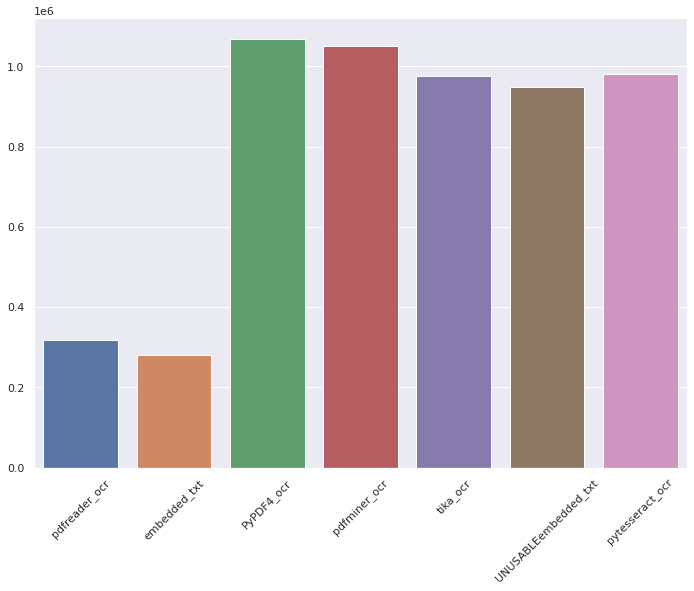

In [24]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(rotation=45)
sns.barplot(x=list(data.keys()), y=list(data.values()))